# 06wk-1: (신경망) – 데이터분석 코딩패턴, 다중클래스 분류

## 1. Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision

## 2. 주요 코드 등

In [1]:
import torch

In [ ]:
torch.utils.data.DataLo

In [ ]:
torch.nn.BCEWithLogitsLoss

```Python
ds = torch.utils.data.TensorDataset(X, y)
dl = torch.utils.data.DataLoader(ds, batch_size = 1024)

net = torch.nn.Sequential(
    torch.nn.Linear(k, 1024), ## k*1024 + 1024
    torch.nn.ReLU(),
    torch.nn.Linear(1024, p), ## 1024*p + p
    torch.nn.Sigmoid()
).to("cuda:0")

loss_fn = torch.nn.BCEWithLogitsLoss() ## 일반화 로지스틱
optimizr = torch.optim.Adam(net.parameters())

##---##
for epoc in range(1, 500) :
    for Xm, ym in dl :
        Xm.to("cuda:0")
        ym.to("cuda:0")

        netout = net(Xm)
        loss = loss_fn(netout, ym)
        optimizr.step()
        optimizr.zero_grad()

    ## train accuracy
    if epoc % 50 == 0 :
        for Xm, ym in dl :
            Xm = Xm.to("cuda:0")
            ym = ym.to("cuda:0")
            s += torch.sum(((net(Xm) > 0.5)*1.0 == ym)*1.0)
        
        acc = s/X.shape[0]
    
        print(f"# of epochs = {epoc},\t acc={acc.item(): .4f}")

XX.to("cuda:0")
yy.to("cuda:0")

test_acc = ((net(XX) > 0.5) == yy).float().mean()
## test_acc = ((net(XX) - yy)**2).mean()
```

## 3. 데이터분석 코딩패턴

`-` 복습

- 시벤코 정리 - train 측면에서 다 맞출 수 있음
- 오버피팅 -> test에서 잘하는 게 의미가 있음
- 드랍아웃 -> 대충대충 학습하면 오히려 오버피팅이 잘 안일어남 -> 성공 / 랜덤포레스트

`-` 알고리즘

- GPU 메모리가 모자람
- 확률적 경사하강법 사용 -> 꼭 자원이 모자라서 이 알고리즘을 만든 것 같지만, SGD는 알고리즘 자체에 장점이 있음
- 데이터를 조금씩 쓰면서 update -> 오버핏을 눌러주는 효과 / 배깅
- 전역 최소값과 로컬 미니멈이 있을 때 국지적 최소값에 빠져도 잘 빠져나옴

> 오늘 할 것 : train/test가 존재하는 데이터 세팅에서 Dropout 레이어, 미니배치, GPU 사용...

### A. 일반적인 train/test 세팅

`-` Step 1 : 데이터 정리

In [2]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True)
to_tensor = torchvision.transforms.ToTensor()
X0 = torch.stack([to_tensor(img) for img, lbl in train_dataset if lbl==0])
X1 = torch.stack([to_tensor(img) for img, lbl in train_dataset if lbl==1])
X = torch.concat([X0,X1],axis=0).reshape(-1,784)
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)
XX0 = torch.stack([to_tensor(img) for img, lbl in test_dataset if lbl==0])
XX1 = torch.stack([to_tensor(img) for img, lbl in test_dataset if lbl==1])
XX = torch.concat([XX0,XX1],axis=0).reshape(-1,784)
yy = torch.tensor([0.0]*len(XX0) + [1.0]*len(XX1)).reshape(-1,1)

tensor([0.])


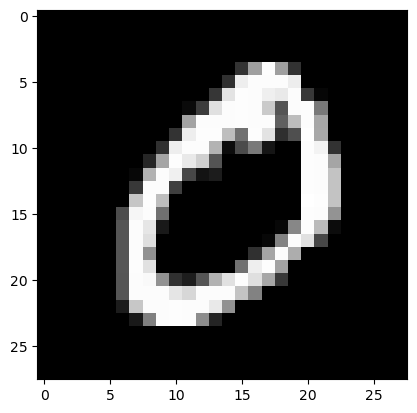

In [3]:
plt.imshow(X[0].reshape(28, 28), cmap = "gray")
print(y[0])

In [6]:
X.shape, y.shape

(torch.Size([12665, 784]), torch.Size([12665, 1]))

In [7]:
XX.shape, yy.shape

(torch.Size([2115, 784]), torch.Size([2115, 1]))

`-` Step2 : 학습 가능한 오브젝트들의 설정

In [27]:
net = torch.nn.Sequential(
    torch.nn.Linear(784, 32),
    torch.nn.ReLU(),
    # torch.nn.Dropout(), ## ReLU의 경우 앞에 써도 됨
    torch.nn.Linear(32, 1),  ## 784*32 + 32개의 파라미터 학습 필요
    torch.nn.Sigmoid()
)

loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters())

`-` Step3 : 학습(= 적합)

In [28]:
for epoc in range(300) :
    yhat = net(X)
    loss = loss_fn(yhat, y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()
    #----에폭 끝----#
    # 에폭마다 보고 싶은 코드를 정리
    if (epoc % 50) == 0 :
        ## 50 에폭마다 정확도 출력
        acc = ((net(X).data > 0.5) == y).float().mean().item()
        print(f"# epochs = {epoc},   \t acc = {acc:.2f}")

# epochs = 0,   	 acc = 0.46
# epochs = 50,   	 acc = 0.47
# epochs = 100,   	 acc = 0.51
# epochs = 150,   	 acc = 0.63
# epochs = 200,   	 acc = 0.82
# epochs = 250,   	 acc = 0.94


`-` Step 4 : 예측 & 결과 분석

* train accuracy

In [34]:
torch.mean(((net(X) > 0.5)*1.0 == y)*1.0).item()

0.976233720779419

* test accuracy

In [35]:
torch.mean(((net(XX) > 0.5)*1.0 == yy)*1.0).item()

0.9839243292808533

> dropout 말고도, early stoping이라고 그냥 정확도가 너무 높아지기 전에 에폭을 멈추는 직관적인 방법도 있음 ㅇㅇ
>
> 멈추는 시점을 validation set을 통해 결정하는 방법도 있음 -> validation set의 평가 지수가 낮아지는 시점에서 멈추는 방법

### B. Dropout 사용(오버피팅은 아니지만...)

`-` Step 1 : 데이터 정리 - pass

In [36]:
pass

`-` Step 2 : 학습을 위한 오브젝트 설정(모델링 과정 포함)

In [43]:
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.Dropout(0.9),  ## 렐루 뒤에 넣어도 됨
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters())

`-` Step3 : 학습(=적합)

In [44]:
for epoc in range(300):
    net.train()  ## train 모드로 전환. 첫 루프에는 train mode지만, 아래에서 디버깅을 위해 evaluation 모드 사용
    #----에폭시작-----#
    # step1 
    yhat = net(X)
    # step2 
    loss = loss_fn(yhat,y)
    # step3     
    loss.backward()
    # step4 
    optimizr.step()
    optimizr.zero_grad()
    #-----에폭끝-----#
    net.eval()  ## 평가를 위해 모드 전환
    # 에폭별로 살펴보고 싶은 뭔가들.. 
    if (epoc % 50) == 0:
        acc = ((net(X).data > 0.5) == y).float().mean()
        print(f"# of epochs = {epoc},\t acc={acc.item(): .2f}")

# of epochs = 0,	 acc= 0.22
# of epochs = 50,	 acc= 0.45
# of epochs = 100,	 acc= 0.63
# of epochs = 150,	 acc= 0.81
# of epochs = 200,	 acc= 0.92
# of epochs = 250,	 acc= 0.96


`-` Step4 : 예측 & 결과 분석

In [49]:
net

Sequential(
  (0): Linear(in_features=784, out_features=32, bias=True)
  (1): Dropout(p=0.9, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=1, bias=True)
  (4): Sigmoid()
)

* train acc

In [45]:
((net(X) > 0.5)*1.0 ==  y).float().mean()

tensor(0.9797)

* test acc

In [46]:
((net(XX) > 0.5)*1.0 ==  yy).float().mean()

tensor(0.9877)

### C. GPU도 사용

`-` 데이터 정리, 오브젝트 설정 변경

In [53]:
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.Dropout(0.9),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
).to("cuda:0")  ## 네트워크 넣어주기
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters())

In [54]:
for epoc in range(300):
    net.train()
    #----에폭시작-----#
    X = X.to("cuda:0") ## 데이터도 넣어주기
    y = y.to("cuda:0") ## 데이터도 넣어주기 : 이건 처음 데이터 정리 과정에서 하는 게 좋을듯
    # step1 
    yhat = net(X)
    # step2 
    loss = loss_fn(yhat,y)
    # step3     
    loss.backward()
    # step4 
    optimizr.step()
    optimizr.zero_grad()
    #-----에폭끝-----#
    net.eval()
    # 에폭별로 살펴보고 싶은 뭔가들.. 
    if (epoc % 50) == 0:
        acc = ((net(X).data > 0.5) == y).float().mean()
        print(f"# of epochs = {epoc},\t acc={acc.item(): .2f}")

# of epochs = 0,	 acc= 0.22
# of epochs = 50,	 acc= 0.45
# of epochs = 100,	 acc= 0.63
# of epochs = 150,	 acc= 0.81
# of epochs = 200,	 acc= 0.92
# of epochs = 250,	 acc= 0.96


* train acc

In [58]:
((net(X) > 0.5) ==  y).float().mean().item()

0.9797868728637695

* test acc

In [59]:
XX = XX.to("cuda:0")
yy = yy.to("cuda:0")
((net(XX) > 0.5) ==  yy).float().mean().item()

0.9881796836853027

### D. 미니배치까지 사용

`-` Step1 : 데이터 정리

In [60]:
X = X.to("cpu")  ## 얘를 올리기에는 너무 큰 상황
y = y.to("cpu")
XX = XX.to("cpu")
yy = yy.to("cpu")

In [71]:
ds = torch.utils.data.TensorDataset(X, y)
dl = torch.utils.data.DataLoader(ds, batch_size = 16, shuffle = True)

In [67]:
# for Xm, ym in dl :
#     print(Xm.shape) # (16, 784)
#     print(ym.shape) # (16, 1)

`-` Step2: 학습가능한 오브젝트들의 설정 (모델링과정 포함)

In [83]:
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
).to("cuda:0")
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters())

`-` Step3 : 학습(=적합)

In [84]:
for epoc in range(3):
    net.train()
    #----에폭시작-----#
    for Xm, ym in dl :
        Xm = Xm.to("cuda:0")  ## 얘는 그나마 작아서 올릴만 함
        ym = ym.to("cuda:0")
        # step1 
        yhat = net(Xm)
        # step2 
        loss = loss_fn(yhat,ym)
        # step3     
        loss.backward()
        # step4 
        optimizr.step()
        optimizr.zero_grad()
    #-----에폭끝-----#
    net.eval()
    # 에폭별로 살펴보고 싶은 뭔가들...
    s = 0
    
    for Xm, ym in dl :
        Xm = Xm.to("cuda:0")
        ym = ym.to("cuda:0")
        s += torch.sum(((net(Xm) > 0.5)*1.0 == ym)*1.0)
        
    acc = s/X.shape[0]

    print(f"# of epochs = {epoc},\t acc={acc.item(): .4f}")

# of epochs = 0,	 acc= 0.9957
# of epochs = 1,	 acc= 0.9961
# of epochs = 2,	 acc= 0.9964


`-` Step4 : 예측 & 결과 분석

In [85]:
net.to("cpu") ## X를 올리긴 힘듦...

Sequential(
  (0): Linear(in_features=784, out_features=32, bias=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=1, bias=True)
  (4): Sigmoid()
)

* train acc

In [86]:
torch.mean(((net(X) > 0.5)*1.0 == y)*1.0)

tensor(0.9964)

`-` test acc

In [88]:
torch.mean(((net(XX) > 0.5)*1.0 == yy)*1.0)

tensor(0.9991)

> 점점 비본질적인 코드가 늘어남. 여러 방법을 추가할수록 귀찮음... -> Trainer의 개념 등장
>
> 직접 하긴 어려우니... 실질적으로 학부 수준에서는 트레이너가 있는 다른 패키지를 써야 함